# Capstone: Deteksi Hoaks Berita Indonesia + Ringkasan Netral (IBM Granite)

**Platform:** Google Colab (GPU) → commit notebook ke GitHub via *File → Save a copy in GitHub*  
**Model:** `ibm-granite/granite-3.1-3b-a800m-instruct` (open, long context)  
**Dataset utama:** IDNHoaxCorpus (CSV) dari GitHub  


In [3]:
!pip -q install --upgrade pip
!pip -q install transformers accelerate bitsandbytes datasets scikit-learn evaluate rouge-score matplotlib pandas numpy tqdm
import os, re, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print('CUDA available:', torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'rouge-score' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rouge-score'. Discussion can be found at https://github.com/pypa/pip/issues/6334
CUDA available: True


PERTAMA.
**mengunduh ZIP repo** IDNHoaxCorpus dari GitHub lalu memuat CSV di folder `dataset/`.

**Catatan label:** dataset menyediakan label `Hoax`, `Valid`, dan `?`.  
Untuk klasifikasi **biner**, kita pakai:
- `Hoax` → `HOAX`
- `Valid` → `NON-HOAX`
- `?` → **dibuang** (tidak jelas)


In [4]:
%%bash
set -e
URL_ZIP="https://codeload.github.com/9uz/IDNHoaxCorpus/zip/refs/heads/main"
OUT_ZIP="IDNHoaxCorpus.zip"
if [ ! -f "$OUT_ZIP" ]; then
  wget -q "$URL_ZIP" -O "$OUT_ZIP"
  unzip -q "$OUT_ZIP"
fi
ls -R | head -n 40


.:
IDNHoaxCorpus-main
IDNHoaxCorpus.zip
sample_data

./IDNHoaxCorpus-main:
DataCorpus.ipynb
dataset
LICENSE
README.md

./IDNHoaxCorpus-main/dataset:
datasetUMPOHoax.csv
index

./sample_data:
anscombe.json
california_housing_test.csv
california_housing_train.csv
mnist_test.csv
mnist_train_small.csv
README.md


In [5]:
import glob, os, pandas as pd
base = 'IDNHoaxCorpus-main'
csv_candidates = glob.glob(os.path.join(base, 'dataset', '*.csv'))
assert len(csv_candidates) > 0, 'Tidak menemukan CSV di folder dataset/. Periksa struktur repo.'
csv_path = csv_candidates[0]
print('Menggunakan file:', csv_path)
df = pd.read_csv(csv_path)
print('Kolom:', df.columns.tolist())
df.head(3)

Menggunakan file: IDNHoaxCorpus-main/dataset/datasetUMPOHoax.csv
Kolom: ['topik', 'keyword', 'tweet', 'gambar', 'url', 'label']


,topik,keyword,tweet,gambar,url,label
0,Air Garam,Air garam sumber energi,Mahasiswa ITS buat pembangkit listrik dari kol...,NaN,https://twitter.com/Klik_iT_indo/status/370802...,hoax
1,Air Garam,Air garam sumber energi,Lampu Dengan Sumber Energi Air Garam Ini Berpo...,NaN,https://twitter.com/Robin_nugraha/status/62854...,hoax
2,Air Garam,Air garam sumber energi,#didUknow Lampu LED yang menggunakan air dan g...,NaN,https://twitter.com/SerbaTauID/status/24731045...,hoax


### Pembersihan kolom & mapping label
Kita cari kolom teks utama (`tweet` atau `text`), normalisasi minimal (hapus URL), serta mapping label biner.


In [6]:
text_col = None
for cand in ['text', 'tweet', 'content', 'judul', 'title']:
    if cand in df.columns:
        text_col = cand; break
assert text_col is not None, 'Tidak menemukan kolom teks. Cek nama kolom di CSV.'

label_col = None
for cand in ['label', 'kelas', 'class', 'category']:
    if cand in df.columns:
        label_col = cand; break
assert label_col is not None, 'Tidak menemukan kolom label. Cek nama kolom di CSV.'

def clean_text(s):
    s = str(s)
    s = re.sub(r'https?://\S+', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df = df[[text_col, label_col]].dropna()
df[text_col] = df[text_col].apply(clean_text)
df[label_col] = df[label_col].astype(str).str.strip().str.lower()

map_bin = {'hoax':'HOAX', 'valid':'NON-HOAX'}
df = df[df[label_col].isin(['hoax','valid'])].copy()
df['label_bin'] = df[label_col].map(map_bin)
df = df[df[text_col].str.len() > 10]
df.head(5)

,tweet,label,label_bin
0,Mahasiswa ITS buat pembangkit listrik dari kol...,hoax,HOAX
1,Lampu Dengan Sumber Energi Air Garam Ini Berpo...,hoax,HOAX
2,#didUknow Lampu LED yang menggunakan air dan g...,hoax,HOAX
3,#tekno Lampu Dengan Sumber Energi Air Garam In...,hoax,HOAX
4,"Green House,lampu darurat dg sumber energi gar...",hoax,HOAX


### Train/Valid/Test split (stratified)


In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df['label_bin'])
train_df, valid_df = train_test_split(train_df, test_size=0.1765, random_state=SEED, stratify=train_df['label_bin'])
# => total ~15% test, 15% valid, 70% train
for name, d in [('train', train_df), ('valid', valid_df), ('test', test_df)]:
    print(name, d.shape, d['label_bin'].value_counts(normalize=True).to_dict())


train (2626, 3) {'HOAX': 0.8092155369383092, 'NON-HOAX': 0.19078446306169078}
valid (564, 3) {'HOAX': 0.8085106382978723, 'NON-HOAX': 0.19148936170212766}
test (563, 3) {'HOAX': 0.8099467140319716, 'NON-HOAX': 0.19005328596802842}


## Baseline cepat: TF‑IDF + Linear Model
Tujuan baseline: patokan sebelum pakai Granite.


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

vec = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
Xtr = vec.fit_transform(train_df[text_col]); Xva = vec.transform(valid_df[text_col]); Xte = vec.transform(test_df[text_col])
ytr = (train_df['label_bin']=='HOAX').astype(int)
yva = (valid_df['label_bin']=='HOAX').astype(int)
yte = (test_df['label_bin']=='HOAX').astype(int)

clf = LogisticRegression(max_iter=3000, class_weight='balanced', n_jobs=None)
clf.fit(Xtr, ytr)
pred_va = clf.predict(Xva)
print('VALIDATION REPORT (Baseline)')
print(classification_report(yva, pred_va, target_names=['NON-HOAX','HOAX']))


VALIDATION REPORT (Baseline)
              precision    recall  f1-score   support

    NON-HOAX       0.51      0.57      0.54       108
        HOAX       0.90      0.87      0.88       456

    accuracy                           0.81       564
   macro avg       0.70      0.72      0.71       564
weighted avg       0.82      0.81      0.82       564



## 3) IBM Granite 3.1 3B *Instruct* (4‑bit) untuk Klasifikasi (few‑shot)
Kita pakai prompt **JSON-only** agar parsing mudah. *Temperature* rendah untuk konsistensi.


In [11]:
# =========================================================
# HYBRID SWEEP (SELF-CONTAINED & GPU-FRIENDLY)
# - Auto-setup: vec/clf, Granite tok+model, granite_predict_batch_v2, shots
# - Sekali panggil Granite untuk union 'zona ragu'
# - Cetak 3 kandidat: Macro-F1, Balanced-Acc, HOAX-recall maks (rec_non ≥ 0.40)
# =========================================================
import os, re, json, random, numpy as np, pandas as pd, torch
from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ---------- Pastikan data & kolom ----------
def _detect_text_col(df):
    return next((c for c in ['tweet','text','content','judul','title','body'] if c in df.columns), None)

assert 'valid_df' in globals() and 'train_df' in globals(), "Butuh train_df dan valid_df."
if 'text_col' not in globals():
    text_col = _detect_text_col(train_df)
    assert text_col is not None, "Tidak menemukan kolom teks (cari: tweet/text/content/judul/title/body)."

# ---------- Pastikan baseline vec/clf ----------
try:
    vec, clf
except NameError:
    vec = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
    Xtr = vec.fit_transform(train_df[text_col])
    Xva = vec.transform(valid_df[text_col])
    ytr = (train_df['label_bin']=='HOAX').astype(int).values
    yva = (valid_df['label_bin']=='HOAX').astype(int).values
    clf = LogisticRegression(max_iter=3000, class_weight='balanced').fit(Xtr, ytr)
else:
    try:
        Xva
    except NameError:
        Xva = vec.transform(valid_df[text_col])

# ---------- Pastikan Granite + fungsi + shots ----------
need_granite = ('granite_predict_batch_v2' not in globals()) or ('shots' not in globals())
if need_granite:
    from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
    import transformers
    transformers.logging.set_verbosity_error()

    MODEL_ID = "ibm-granite/granite-3.1-3b-a800m-instruct"
    bnb = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
    )

    if 'tok' not in globals() or 'model' not in globals():
        tok = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_ID, device_map="auto", quantization_config=bnb, trust_remote_code=True
        )
        if tok.pad_token is None and tok.eos_token is not None:
            tok.pad_token = tok.eos_token
            if hasattr(model, "config"): model.config.pad_token_id = tok.eos_token_id

    HEADER_VARIANTS = [
        "Klasifikasikan teks sebagai 'HOAX' atau 'NON-HOAX'. Jawab HANYA JSON: {\"label\":\"HOAX\"} atau {\"label\":\"NON-HOAX\"}.",
        "Tentukan apakah teks termasuk HOAX atau NON-HOAX. Output hanya JSON valid tanpa teks lain.",
        "Evaluasi klaim. Pilih HOAX atau NON-HOAX. Keluarkan hanya JSON valid."
    ]

    def build_prompt_fs(text, header, shots):
        ex = "\n\n".join(
            f"Contoh {i+1}:\nTEKS: {s['text']}\nJAWABAN: {{\"label\":\"{s['label']}\"}}"
            for i, s in enumerate(shots)
        )
        return (
            "You are an accurate Indonesian misinformation detector.\n"
            + header + "\n"
            "Jangan bias karena frekuensi kelas; fokus pada isi klaim & indikator misinformasi.\n"
            "Jangan sertakan teks lain selain JSON label.\n\n"
            + ex + "\n\n"
            + f"TEKS: {text}\nJAWABAN:"
        )

    def _parse_json_label(s):
        m = re.search(r"\{[^{}]*\}", s)
        if not m:
            return 0
        try:
            obj = json.loads(m.group(0))
            lab = str(obj.get("label","NON-HOAX")).upper().strip()
            return 1 if lab=="HOAX" else 0
        except:
            return 0

    @torch.inference_mode()
    def _batch_generate(prompts, max_new_tokens=6):
        enc = tok(prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
        out = model.generate(
            **enc, max_new_tokens=max_new_tokens, do_sample=False, num_beams=1,
            pad_token_id=tok.pad_token_id, eos_token_id=tok.eos_token_id
        )
        gen_ids = out[:, enc["input_ids"].shape[1]:]
        return tok.batch_decode(gen_ids, skip_special_tokens=True)

    def granite_predict_batch_v2(texts, shots, max_new_tokens=6, batch_size=1):
        preds = []
        for i0 in range(0, len(texts), batch_size):
            batch = texts[i0:i0+batch_size]
            prompts = []
            for header in HEADER_VARIANTS:
                for t in batch:
                    prompts.append(build_prompt_fs(t, header, shots))
            outs = _batch_generate(prompts, max_new_tokens=max_new_tokens)
            B = len(batch); H = len(HEADER_VARIANTS)
            for j in range(B):
                votes = []
                for h in range(H):
                    votes.append(_parse_json_label(outs[h*B + j]))
                preds.append(1 if sum(votes) > (len(votes)-sum(votes)) else 0)
        return np.array(preds, dtype=int)

    def make_few_shot_examples(df, k_per_label=5, max_chars=240, seed=42):
        rng = np.random.RandomState(seed)
        ex = []
        for lab in ["HOAX","NON-HOAX"]:
            sub = df[df['label_bin']==lab]
            k = min(k_per_label, len(sub))
            for t in sub.sample(k, random_state=seed)[text_col].tolist():
                t = re.sub(r"\s+", " ", str(t))[:max_chars]
                ex.append({"text": t, "label": lab})
        rng.shuffle(ex); return ex

    shots = make_few_shot_examples(train_df, k_per_label=5, max_chars=240, seed=SEED)

# ---------- Sweep hemat GPU ----------
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:true"

texts  = valid_df[text_col].tolist()
y_true = (valid_df['label_bin']=='HOAX').astype(int).values
proba_va = clf.predict_proba(Xva)[:,1]  # prob HOAX dari LR

centers = np.array([0.45, 0.50, 0.55])   # pusat threshold
margins = np.array([0.08, 0.12])         # lebar zona ragu

# UNION undecided -> Granite sekali
undec_union = set()
for c in centers:
    for m in margins:
        low  = float(np.clip(c - m, 0.01, 0.99))
        high = float(np.clip(c + m, 0.01, 0.99))
        undec_union.update(np.where((proba_va > low) & (proba_va < high))[0].tolist())
undec_union = sorted(undec_union)
print(f"Total 'zona ragu' (union semua kombinasi): {len(undec_union)} contoh")

gmap = {}
if len(undec_union):
    texts_unc = [texts[i] for i in undec_union]
    granite_preds_union = granite_predict_batch_v2(texts_unc, shots, max_new_tokens=6, batch_size=1)
    gmap = {idx: int(pred) for idx, pred in zip(undec_union, granite_preds_union)}
    torch.cuda.empty_cache()

def hybrid_predict_from_cache(proba, gmap, high, low):
    yhat = np.zeros_like(proba, dtype=int)
    yhat[proba >= high] = 1
    yhat[proba <= low]  = 0
    undec = np.where((proba > low) & (proba < high))[0]
    for i in undec:
        yhat[i] = gmap.get(int(i), 0)   # default NON-HOAX kalau tak ada
    return yhat

# Evaluasi grid dari cache
results = []
for c in centers:
    for m in margins:
        low  = float(np.clip(c - m, 0.01, 0.99))
        high = float(np.clip(c + m, 0.01, 0.99))
        yhat = hybrid_predict_from_cache(proba_va, gmap, high, low)
        macro = f1_score(y_true, yhat, average='macro')
        bacc  = balanced_accuracy_score(y_true, yhat)
        pr, rc, f1, sup = precision_recall_fscore_support(y_true, yhat, labels=[0,1], zero_division=0)
        results.append({
            "center": c, "margin": m, "low": low, "high": high,
            "macroF1": macro, "bacc": bacc,
            "prec_non": float(pr[0]), "rec_non": float(rc[0]), "f1_non": float(f1[0]),
            "prec_hoax": float(pr[1]), "rec_hoax": float(rc[1]), "f1_hoax": float(f1[1]),
            "yhat": yhat
        })

best_macro    = max(results, key=lambda r: r["macroF1"])
best_bacc     = max(results, key=lambda r: r["bacc"])
feasible      = [r for r in results if r["rec_non"] >= 0.40]
best_hoax_rec = max(feasible, key=lambda r: r["rec_hoax"]) if feasible else max(results, key=lambda r: r["rec_hoax"])

def _show(name, r):
    print(f"\n=== {name} ===")
    print(f"high={r['high']:.2f}  low={r['low']:.2f}  (center={r['center']:.2f}, margin={r['margin']:.2f})")
    print(f"Macro-F1={r['macroF1']:.3f}  Balanced-Acc={r['bacc']:.3f}")
    print(f"NON-HOAX: P={r['prec_non']:.2f} R={r['rec_non']:.2f} F1={r['f1_non']:.2f}  |  "
          f"HOAX: P={r['prec_hoax']:.2f} R={r['rec_hoax']:.2f} F1={r['f1_hoax']:.2f}")
    print(classification_report(y_true, r["yhat"], target_names=['NON-HOAX','HOAX']))

_show("HYBRID — Macro-F1 terbaik", best_macro)
_show("HYBRID — Balanced Accuracy terbaik", best_bacc)
_show("HYBRID — HOAX recall maks (NON-HOAX recall ≥ 0.40)", best_hoax_rec)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.60G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Total 'zona ragu' (union semua kombinasi): 290 contoh

=== HYBRID — Macro-F1 terbaik ===
high=0.58  low=0.42  (center=0.50, margin=0.08)
Macro-F1=0.682  Balanced-Acc=0.685
NON-HOAX: P=0.48 R=0.50 F1=0.49  |  HOAX: P=0.88 R=0.87 F1=0.88
              precision    recall  f1-score   support

    NON-HOAX       0.48      0.50      0.49       108
        HOAX       0.88      0.87      0.88       456

    accuracy                           0.80       564
   macro avg       0.68      0.69      0.68       564
weighted avg       0.80      0.80      0.80       564


=== HYBRID — Balanced Accuracy terbaik ===
high=0.63  low=0.47  (center=0.55, margin=0.08)
Macro-F1=0.665  Balanced-Acc=0.694
NON-HOAX: P=0.41 R=0.58 F1=0.48  |  HOAX: P=0.89 R=0.80 F1=0.85
              precision    recall  f1-score   support

    NON-HOAX       0.41      0.58      0.48       108
        HOAX       0.89      0.80      0.85       456

    accuracy                           0.76       564
   macro avg       0.65     

# FINALISASI HYBRID (LOCK THRESHOLD) + EVAL VALID/TEST + SAVE ARTIFACTS
# Mode: Macro-F1 terbaik (high=0.58, low=0.42)


In [12]:
# =========================================================
# FINALISASI HYBRID (LOCK THRESHOLD) + EVAL VALID/TEST + SAVE ARTIFACTS
# Mode yang DIKUNCI: Macro-F1 terbaik → high=0.58, low=0.42
# =========================================================
import os, json, numpy as np, pandas as pd, torch, joblib, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from datetime import datetime

# --- prasyarat dari sel sebelumnya ---
assert 'vec' in globals() and 'clf' in globals(), "vec/clf belum ada."
assert 'train_df' in globals() and 'valid_df' in globals() and 'test_df' in globals(), "split belum ada."
assert 'text_col' in globals(), "text_col belum ada."
assert 'granite_predict_batch_v2' in globals() and 'shots' in globals(), "Granite fn/shots belum ada."

# --- threshold final (LOCK) ---
HIGH, LOW = 0.58, 0.42

# --- util: hybrid dengan cache Granite per split ---
def hybrid_with_cache(df_split, low=LOW, high=HIGH, max_new_tokens=6, batch_size=1):
    texts = df_split[text_col].tolist()
    y_true = (df_split['label_bin']=='HOAX').astype(int).values
    X = vec.transform(texts)
    proba = clf.predict_proba(X)[:,1]

    undec_idx = np.where((proba > low) & (proba < high))[0]
    gpred = np.zeros(len(undec_idx), dtype=int)
    if len(undec_idx):
        t_unc = [texts[i] for i in undec_idx]
        gpred = granite_predict_batch_v2(t_unc, shots, max_new_tokens=max_new_tokens, batch_size=batch_size)
        torch.cuda.empty_cache()

    yhat = np.zeros_like(proba, dtype=int)
    yhat[proba >= high] = 1
    yhat[proba <= low]  = 0
    for j,i in enumerate(undec_idx): yhat[i] = int(gpred[j])
    return texts, y_true, yhat, proba, undec_idx

def plot_cm(cm, labels, title, path_png):
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(title)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='black')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.savefig(path_png, dpi=160)
    plt.close(fig)

# --- jalankan untuk VALID & TEST ---
out_dir = "artifacts"
os.makedirs(out_dir, exist_ok=True)
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

def eval_and_save(df_split, split_name):
    texts, y_true, yhat, proba, undec_idx = hybrid_with_cache(df_split, LOW, HIGH)
    rep_txt = classification_report(y_true, yhat, target_names=['NON-HOAX','HOAX'])
    rep = classification_report(y_true, yhat, target_names=['NON-HOAX','HOAX'], output_dict=True)
    macroF1 = f1_score(y_true, yhat, average='macro')
    bacc    = balanced_accuracy_score(y_true, yhat)
    cm = confusion_matrix(y_true, yhat, labels=[0,1]).tolist()

    print(f"\n[{split_name.upper()}] HYBRID (locked)  high={HIGH:.2f} low={LOW:.2f}")
    print(rep_txt)
    print("Confusion matrix [NON-HOAX, HOAX]:", cm)
    print(f"Macro-F1={macroF1:.3f}  Balanced-Acc={bacc:.3f}  Undecided={len(undec_idx)}")

    # simpan prediksi csv
    df_out = pd.DataFrame({
        "text": texts,
        "y_true": y_true,
        "proba_hoax": proba,
        "pred": yhat
    })
    csv_path = os.path.join(out_dir, f"{split_name}_pred_hybrid_{stamp}.csv")
    df_out.to_csv(csv_path, index=False)

    # simpan report json
    report = {
        "split": split_name,
        "thresholds": {"low": float(LOW), "high": float(HIGH)},
        "macro_f1": float(macroF1),
        "balanced_accuracy": float(bacc),
        "classification_report": rep,
        "confusion_matrix_labels": ["NON-HOAX","HOAX"],
        "confusion_matrix": cm,
        "undecided_count": int(len(undec_idx))
    }
    json_path = os.path.join(out_dir, f"{split_name}_report_hybrid_{stamp}.json")
    with open(json_path, "w") as f: json.dump(report, f, ensure_ascii=False, indent=2)

    # simpan CM PNG
    png_path = os.path.join(out_dir, f"{split_name}_cm_{stamp}.png")
    plot_cm(cm, ['NON-HOAX','HOAX'], f'Confusion Matrix ({split_name.upper()})', png_path)

    return csv_path, json_path, png_path, macroF1, bacc

valid_csv, valid_json, valid_png, valid_mf1, valid_bacc = eval_and_save(valid_df, "valid")
test_csv,  test_json,  test_png,  test_mf1,  test_bacc  = eval_and_save(test_df,  "test")

# --- simpan model baseline & threshold untuk inferensi ---
joblib.dump(vec, os.path.join(out_dir, f"tfidf_vectorizer_{stamp}.joblib"))
joblib.dump(clf, os.path.join(out_dir, f"logreg_balanced_{stamp}.joblib"))
with open(os.path.join(out_dir, f"thresholds_{stamp}.json"), "w") as f:
    json.dump({"low": LOW, "high": HIGH}, f, indent=2)

# --- buat snippet README otomatis ---
md = f"""### Hasil Akhir (Hybrid: TF-IDF+LR + Granite few-shot, JSON-only)
- Threshold final: **high={HIGH:.2f}**, **low={LOW:.2f}** (Macro-F1 terbaik).
- **VALID** — Macro-F1: **{valid_mf1:.3f}**, Balanced-Acc: **{valid_bacc:.3f}**.
- **TEST**  — Macro-F1: **{test_mf1:.3f}**, Balanced-Acc: **{test_bacc:.3f}**.

Artefak:
- `{os.path.basename(valid_csv)}`, `{os.path.basename(test_csv)}`
- `{os.path.basename(valid_json)}`, `{os.path.basename(test_json)}`
- `{os.path.basename(valid_png)}`, `{os.path.basename(test_png)}`
"""
readme_snip = os.path.join(out_dir, f"README_metrics_snippet_{stamp}.md")
with open(readme_snip, "w") as f:
    f.write(md)

print("\n✅ Files saved in ./artifacts:")
for p in [valid_csv, valid_json, valid_png, test_csv, test_json, test_png,
          os.path.join(out_dir, f"tfidf_vectorizer_{stamp}.joblib"),
          os.path.join(out_dir, f"logreg_balanced_{stamp}.joblib"),
          os.path.join(out_dir, f"thresholds_{stamp}.json"),
          readme_snip]:
    print(" -", p)

print("\n👉 Salin isi file README_metrics_snippet_*.md ke README utama.")



[VALID] HYBRID (locked)  high=0.58 low=0.42
              precision    recall  f1-score   support

    NON-HOAX       0.47      0.51      0.49       108
        HOAX       0.88      0.87      0.87       456

    accuracy                           0.80       564
   macro avg       0.68      0.69      0.68       564
weighted avg       0.80      0.80      0.80       564

Confusion matrix [NON-HOAX, HOAX]: [[55, 53], [61, 395]]
Macro-F1=0.682  Balanced-Acc=0.688  Undecided=129

[TEST] HYBRID (locked)  high=0.58 low=0.42
              precision    recall  f1-score   support

    NON-HOAX       0.46      0.57      0.51       107
        HOAX       0.89      0.84      0.87       456

    accuracy                           0.79       563
   macro avg       0.67      0.71      0.69       563
weighted avg       0.81      0.79      0.80       563

Confusion matrix [NON-HOAX, HOAX]: [[61, 46], [73, 383]]
Macro-F1=0.686  Balanced-Acc=0.705  Undecided=142

✅ Files saved in ./artifacts:
 - artifacts

**Evaluasi**

## 4) Summarization (Granite)
Ringkasan 3–5 kalimat + daftar *key_claims* dalam JSON.


In [16]:
import os, re, json, random, numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from collections import Counter
from datetime import datetime

# ---- Prasyarat minimal: model & tokenizer Granite sudah ada dari sel sebelumnya ----
assert 'tok' in globals() and 'model' in globals(), "Tokenizer/model Granite belum ada. Jalankan sel Granite dulu."
assert 'train_df' in globals() and 'valid_df' in globals() and 'text_col' in globals(), "train_df/valid_df/text_col belum ada."
# test_df optional; kalau tidak ada, pakai valid_df untuk demo ringkasan
df_sum = test_df if 'test_df' in globals() else valid_df

# ---- Prompt JSON-only untuk ringkasan ----
def sum_prompt(text):
    return (
        "Ringkas isi teks berikut (3–5 kalimat) dalam Bahasa Indonesia, netral, tanpa opini.\n"
        "Sertakan 'key_claims' berupa bullet pendek.\n"
        "Balas HANYA JSON valid: {\"summary\": \"...\", \"key_claims\": [\"...\", \"...\"]}.\n"
        f"TEKS: {text}\nJAWABAN:"
    )

def parse_sum_json(s):
    m = re.search(r'\{[^{}]*\}', s, flags=re.S)
    if not m:
        return {"summary":"", "key_claims":[]}
    try:
        obj = json.loads(m.group(0))
        summ = str(obj.get("summary","")).strip()
        claims = obj.get("key_claims", [])
        if not isinstance(claims, list): claims = [str(claims)]
        claims = [str(x).strip() for x in claims if str(x).strip()]
        return {"summary": summ, "key_claims": claims}
    except Exception:
        return {"summary":"", "key_claims":[]}

@torch.inference_mode()
def _generate_summ(prompts, max_new_tokens=120, do_sample=False, temperature=0.3):
    enc = tok(prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
    gen_kwargs = dict(
        max_new_tokens=max_new_tokens, num_beams=1,
        pad_token_id=tok.pad_token_id, eos_token_id=tok.eos_token_id
    )
    if do_sample:
        gen_kwargs.update(dict(do_sample=True, temperature=float(temperature), top_p=0.9))
    else:
        gen_kwargs.update(dict(do_sample=False))
    out = model.generate(**enc, **gen_kwargs)
    gen_ids = out[:, enc["input_ids"].shape[1]:]
    return tok.batch_decode(gen_ids, skip_special_tokens=True)

def granite_summarize(texts, batch_size=1, max_new_tokens=120, do_sample=False, temperature=0.3):
    outs = []
    for i0 in range(0, len(texts), batch_size):
        batch = texts[i0:i0+batch_size]
        prompts = [sum_prompt(t) for t in batch]
        dec = _generate_summ(prompts, max_new_tokens=max_new_tokens, do_sample=do_sample, temperature=temperature)
        for p, d in zip(prompts, dec):
            completion = d  # tidak perlu pemotongan, kita sudah decode completion-only
            outs.append(parse_sum_json(completion))
    return outs

In [21]:
N_DEMO = min(5, len(df_sum))
demo_texts = df_sum[text_col].astype(str).tolist()[:N_DEMO]
sums = granite_summarize(demo_texts, batch_size=1, max_new_tokens=120, do_sample=False)  # greedy untuk konsistensi

print("== SAMPLE SUMMARIES ==")
for i, obj in enumerate(sums, 1):
    print(f"[{i}] SUMMARY:\n", obj.get('summary',''))
    print('key_claims:', obj.get('key_claims', []))
    print('-'*80)



== SAMPLE SUMMARIES ==
[1] SUMMARY:
 
key_claims: []
--------------------------------------------------------------------------------
[2] SUMMARY:
 Sabtu minggu libur, senen selasa juga libur, krna darah tinggi naek akibat makan daging kambing..!!
key_claims: ['Sabtu minggu libur', 'senen selasa juga libur', 'darah tinggi naek akibat makan daging kambing..!!']
--------------------------------------------------------------------------------
[3] SUMMARY:
 Usus Buntu Bukan Disebabkan Oleh Menelan Biji Jambu Dokter Sehat,...
key_claims: ['Pakar kesehatan dan gizi bernama Inge Permadhi menyebutkan bahwa tanpa sengaja menelan biji jambu atau biji...']
--------------------------------------------------------------------------------
[4] SUMMARY:
 
key_claims: []
--------------------------------------------------------------------------------
[5] SUMMARY:
 
key_claims: []
--------------------------------------------------------------------------------


## 5) Insight & visualisasi ringkas
- Distribusi kelas
- Rata-rata panjang teks per kelas
- Top kata (ngram) per kelas (sederhana)


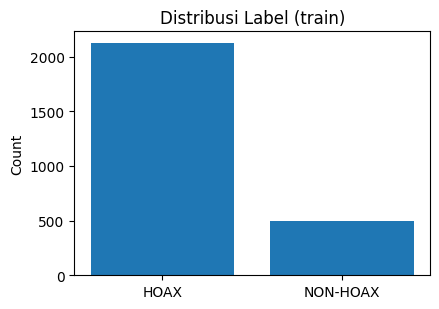

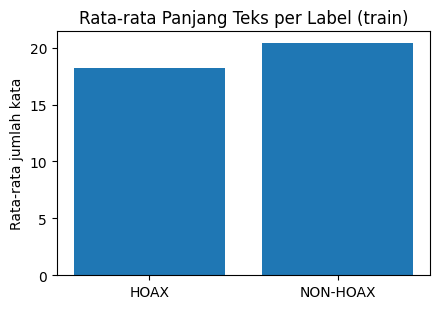

Rata-rata panjang teks per label (train):
label_bin
HOAX        18.199059
NON-HOAX    20.409182
Name: len, dtype: float64


In [22]:
# ---- EDA: distribusi label + panjang teks ----
train_df['len'] = train_df[text_col].astype(str).str.split().apply(len)
lab_counts = train_df['label_bin'].value_counts().reindex(['HOAX','NON-HOAX']).fillna(0)

fig1, ax1 = plt.subplots(figsize=(4.5,3.2))
ax1.bar(lab_counts.index, lab_counts.values)
ax1.set_title('Distribusi Label (train)')
ax1.set_ylabel('Count')
fig1.tight_layout()

avg_len = train_df.groupby('label_bin')['len'].mean().reindex(['HOAX','NON-HOAX'])

fig2, ax2 = plt.subplots(figsize=(4.5,3.2))
ax2.bar(avg_len.index, avg_len.values)
ax2.set_title('Rata-rata Panjang Teks per Label (train)')
ax2.set_ylabel('Rata-rata jumlah kata')
fig2.tight_layout()

plt.show()
print("Rata-rata panjang teks per label (train):")
print(avg_len)



In [23]:
# ---- Top terms per label (sederhana) ----
def top_terms(texts, k=20):
    toks = []
    for x in texts:
        toks.extend(re.findall(r"[\w']+", str(x).lower()))
    cnt = Counter(toks)
    return cnt.most_common(k)

top_hoax = top_terms(train_df[train_df['label_bin']=='HOAX'][text_col].tolist(), k=20)
top_non  = top_terms(train_df[train_df['label_bin']=='NON-HOAX'][text_col].tolist(), k=20)
print("\nTop terms HOAX:", top_hoax)
print("Top terms NON-HOAX:", top_non)

# Simpan artefak
os.makedirs("artifacts", exist_ok=True)
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# EDA PNG
p1 = f"artifacts/eda_label_dist_train_{stamp}.png"
p2 = f"artifacts/eda_avg_len_train_{stamp}.png"
fig1.savefig(p1, dpi=160); fig2.savefig(p2, dpi=160)

# Top terms JSON
top_json = {
    "top_terms_hoax": top_hoax,
    "top_terms_non_hoax": top_non
}
with open(f"artifacts/top_terms_{stamp}.json","w") as f:
    json.dump(top_json, f, ensure_ascii=False, indent=2)

# Metrics & sample summaries JSON
SEED_val = int(SEED) if 'SEED' in globals() else None
metrics = {
  'seed': SEED_val,
  'n_train': int(train_df.shape[0]),
  'n_valid': int(valid_df.shape[0]),
  'n_test': int(df_sum.shape[0]),
  'threshold_low': float(LOW) if 'LOW' in globals() else None,
  'threshold_high': float(HIGH) if 'HIGH' in globals() else None
}
with open(f'artifacts/metrics_{stamp}.json','w') as f: json.dump(metrics, f, ensure_ascii=False, indent=2)
with open(f'artifacts/sample_summaries_{stamp}.json','w') as f: json.dump(sums, f, ensure_ascii=False, indent=2)

print("\n✅ Disimpan ke ./artifacts:")
print(" -", p1)
print(" -", p2)
print(" -", f"artifacts/top_terms_{stamp}.json")
print(" -", f"artifacts/metrics_{stamp}.json")
print(" -", f"artifacts/sample_summaries_{stamp}.json")


Top terms HOAX: [('di', 532), ('dan', 502), ('yang', 428), ('bisa', 343), ('ini', 338), ('yg', 293), ('untuk', 291), ('dari', 222), ('ada', 209), ('itu', 204), ('air', 189), ('dengan', 182), ('vaksin', 179), ('makan', 178), ('covid', 174), ('mengandung', 168), ('tidak', 153), ('menyebabkan', 151), ('berbahaya', 147), ('kanker', 146)]
Top terms NON-HOAX: [('yang', 175), ('dan', 146), ('manfaat', 145), ('untuk', 118), ('di', 108), ('ini', 93), ('bisa', 91), ('tidak', 77), ('kesehatan', 73), ('dari', 69), ('dengan', 55), ('ada', 53), ('salah', 51), ('covid', 51), ('buah', 50), ('air', 48), ('19', 48), ('itu', 47), ('hoax', 44), ('yg', 43)]

✅ Disimpan ke ./artifacts:
 - artifacts/eda_label_dist_train_20250831-163235.png
 - artifacts/eda_avg_len_train_20250831-163235.png
 - artifacts/top_terms_20250831-163235.json
 - artifacts/metrics_20250831-163235.json
 - artifacts/sample_summaries_20250831-163235.json


## 6) Simpan artefak hasil (opsional)
Menyimpan metrik ringkas & contoh ringkasan untuk dokumentasi.


In [24]:
os.makedirs("artifacts", exist_ok=True)
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")